# Este notebook es para analizar los titulares de la página del tiempo

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from wordcloud import WordCloud

from utils import *


## Ingreso a la página web y extracción de los titulares

In [2]:
driver = webdriver.Chrome()
driver.get('https://www.eltiempo.com/')

titulos = []
try:
    titulares = WebDriverWait(driver, 20).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h3 a'))
    )
    for titular in titulares:
            if titular.text != '':
                titulos.append(titular.text.strip().split('\n')[0])

finally:
    driver.quit()

Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event)


In [3]:
with open('titulares.txt', 'r', encoding='utf-8') as f:
    titulares_guardados = f.readlines()

titulares_guardados = [titular.strip() for titular in titulares_guardados]

In [4]:
with open('titulares.txt', 'w', encoding='utf-8') as f:
    for titulo in set(titulares_guardados):
        f.write(titulo + '\n')

    for titulo in titulos:
        if titulo not in titulares_guardados:
           f.write(titulo + '\n')

## Limpieza del texto

In [5]:
with open('titulares.txt', 'r', encoding='utf-8') as f:
    titulares = f.readlines()

titulares = [titular.strip() for titular in titulares]

In [6]:
titulares = Texto(textos = titulares, palabras_parada=['vivo', 'video'])

In [7]:
df = pd.DataFrame({
    'titular': titulares.textos,
    'titular_limpio': titulares.textos_limpios
})
df.head()

,titular,titular_limpio
0,Las duras advertencias del Tribunal de Bogotá ...,duras advertencias tribunal bogota jueza caso ...
1,Juez otorgó detención domiciliaria a militares...,juez otorgo detencion domiciliaria militares p...
2,"Ana María Guzmán, nominada al premio Golden Gi...",maria guzman nominada premio golden girl mismo...
3,Volcamiento de un camión en la autopista sur d...,volcamiento camion autopista dejo hombre falle...
4,¿Quién es Eric Adams? El desconcertante e ilim...,eric adams desconcertante ilimitado alcalde nu...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   titular         796 non-null    object
 1   titular_limpio  796 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


## Análisis de palabras más comunes y nube de palabras

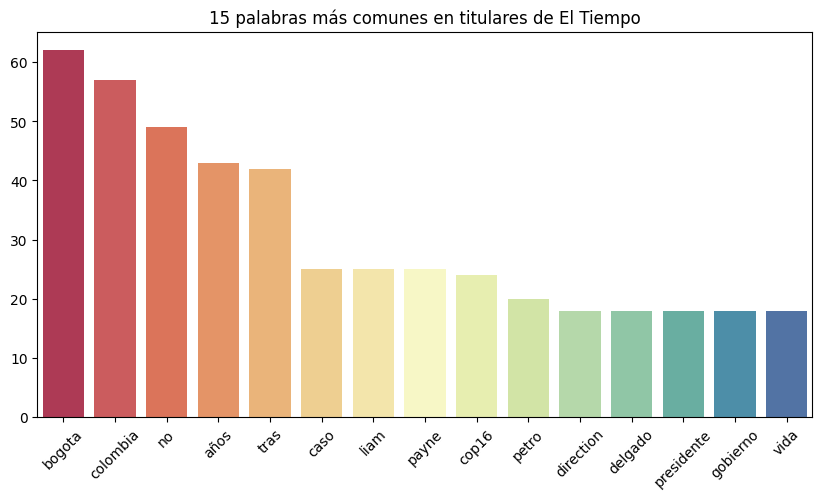

In [9]:
# Palabras más comunes
palabras_comunes = titulares.palabras_mas_comunes(n_palabras=15, plot=True)

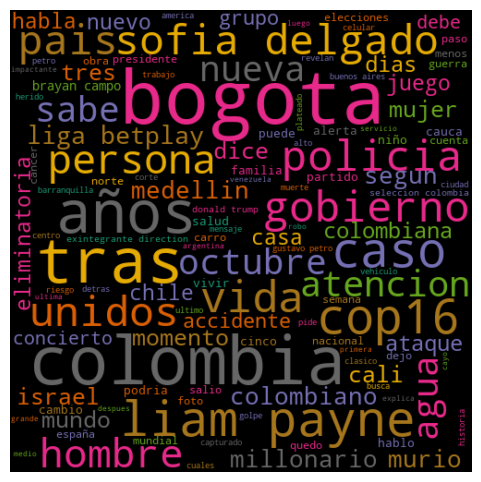

In [10]:
wordcloud = WordCloud(width=500, 
                      height=500, 
                      max_font_size=80, 
                      max_words=120, 
                      background_color='black', 
                      colormap='Dark2_r').generate(titulares.union_textos)

plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelos de Topic Modeling

In [11]:
corpus = titulares.corpus
corpus_tfidf = titulares.corpus_tfidf
dictionary = titulares.diccionario
doc_tok = titulares.doc_tok(titulares.textos_limpios)

### LSI

In [12]:
modelo_corpus_lsi = finding_model(corpus, dictionary, doc_tok, True, 12, min_topics=4)
modelo_tfidf_lsi = finding_model(corpus_tfidf, dictionary, doc_tok, True, 12, min_topics=4)

print(modelo_corpus_lsi)
print(modelo_tfidf_lsi)

(11, 0.4145716656586854)
(7, 0.4876217154200238)


### LDA

In [13]:
modelo_corpus_lda = finding_model(corpus, dictionary, doc_tok, False, 12, min_topics=4)
modelo_tfidf_lda = finding_model(corpus_tfidf, dictionary, doc_tok, False, 12, min_topics=4)

print(modelo_corpus_lda)
print(modelo_tfidf_lda)

(4, 0.581332657127107)
(8, 0.6687733972565935)


### Análisis para el mejor modelo de LSI

In [14]:
if modelo_corpus_lsi[1] > modelo_tfidf_lsi[1]:
    lsi_model = LsiModel(corpus=corpus, num_topics=modelo_corpus_lsi[0], id2word=dictionary)
else:
    lsi_model = LsiModel(corpus=corpus_tfidf, num_topics=modelo_tfidf_lsi[0], id2word=dictionary)

for i in lsi_model.print_topics():
    print(i)

(0, '-0.448*"payne" + -0.448*"liam" + -0.396*"direction" + -0.268*"exintegrante" + -0.201*"argentina" + -0.172*"aires" + -0.172*"buenos" + -0.139*"fallecio" + -0.135*"tras" + -0.122*"muerte"')
(1, '-0.353*"sofia" + -0.353*"delgado" + -0.317*"niña" + -0.262*"brayan" + -0.260*"campo" + -0.209*"asesino" + -0.157*"confeso" + -0.147*"cauca" + -0.136*"valle" + -0.131*"colombia"')
(2, '-0.292*"colombia" + -0.226*"cop16" + -0.213*"bogota" + -0.197*"liga" + -0.196*"minuto" + -0.195*"betplay" + 0.162*"sofia" + 0.158*"delgado" + -0.142*"petro" + -0.141*"millonarios"')
(3, '0.367*"liga" + 0.362*"betplay" + 0.259*"millonarios" + 0.210*"minuto" + -0.185*"colombia" + 0.157*"america" + 0.152*"siga" + 0.139*"fecha" + 0.136*"juego" + -0.136*"no"')
(4, '0.460*"colombia" + -0.380*"bogota" + 0.216*"cop16" + -0.165*"caso" + -0.131*"agua" + 0.131*"chile" + -0.130*"uribe" + 0.119*"eliminatoria" + 0.118*"seleccion" + -0.117*"minuto"')
(5, '-0.454*"petro" + -0.362*"presidente" + -0.213*"gustavo" + -0.208*"inves

In [15]:
# un titular se asisganará al tema con mayor peso (influencia)
temas_lsi = []
for doc in corpus:
    topic_distribution = lsi_model[doc]
    dominant_topic = max(topic_distribution, key=lambda x: abs(x[1]))
    temas_lsi.append(dominant_topic[0])

df['tema_lsi'] = temas_lsi

### Análisis para el mejor modelo de LDA

In [16]:
if modelo_corpus_lda[1] > modelo_tfidf_lda[1]:
    lda_model = LdaModel(corpus=corpus, num_topics=modelo_corpus_lda[0], id2word=dictionary)
else:
    lda_model = LdaModel(corpus=corpus_tfidf, num_topics=modelo_tfidf_lda[0], id2word=dictionary)

for i in lda_model.print_topics():
    print(i)

(0, '0.003*"gobierno" + 0.002*"petro" + 0.002*"no" + 0.002*"presidencial" + 0.002*"fuero" + 0.002*"medico" + 0.002*"cabeza" + 0.002*"mesas" + 0.002*"huracan" + 0.002*"beneficios"')
(1, '0.002*"bogota" + 0.002*"octubre" + 0.002*"cop16" + 0.002*"menos" + 0.002*"territorios" + 0.002*"nadaismo" + 0.002*"margarita" + 0.002*"dice" + 0.002*"deportivo" + 0.002*"camioneta"')
(2, '0.003*"colombia" + 0.003*"bogota" + 0.002*"no" + 0.002*"juego" + 0.002*"tras" + 0.002*"años" + 0.002*"agua" + 0.002*"liga" + 0.002*"nivel" + 0.002*"expareja"')
(3, '0.003*"unidos" + 0.002*"bogota" + 0.002*"sabe" + 0.002*"no" + 0.002*"momento" + 0.002*"minuto" + 0.002*"niños" + 0.002*"todossomosvoragine" + 0.002*"allende" + 0.002*"habla"')
(4, '0.003*"tres" + 0.002*"colombia" + 0.002*"niña" + 0.002*"caso" + 0.002*"policia" + 0.002*"reforma" + 0.002*"sofia" + 0.002*"delgado" + 0.002*"años" + 0.002*"no"')
(5, '0.002*"no" + 0.002*"muerte" + 0.002*"liam" + 0.002*"payne" + 0.002*"bogota" + 0.002*"tras" + 0.002*"vida" + 0.002

In [17]:
temas_lda = []
for i, doc in enumerate(corpus):
    topic_distribution = lda_model.get_document_topics(doc)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])
    temas_lda.append(dominant_topic[0])

df['tema_lda'] = temas_lda


## Análisis para los resultados de aplicar lsi y lda

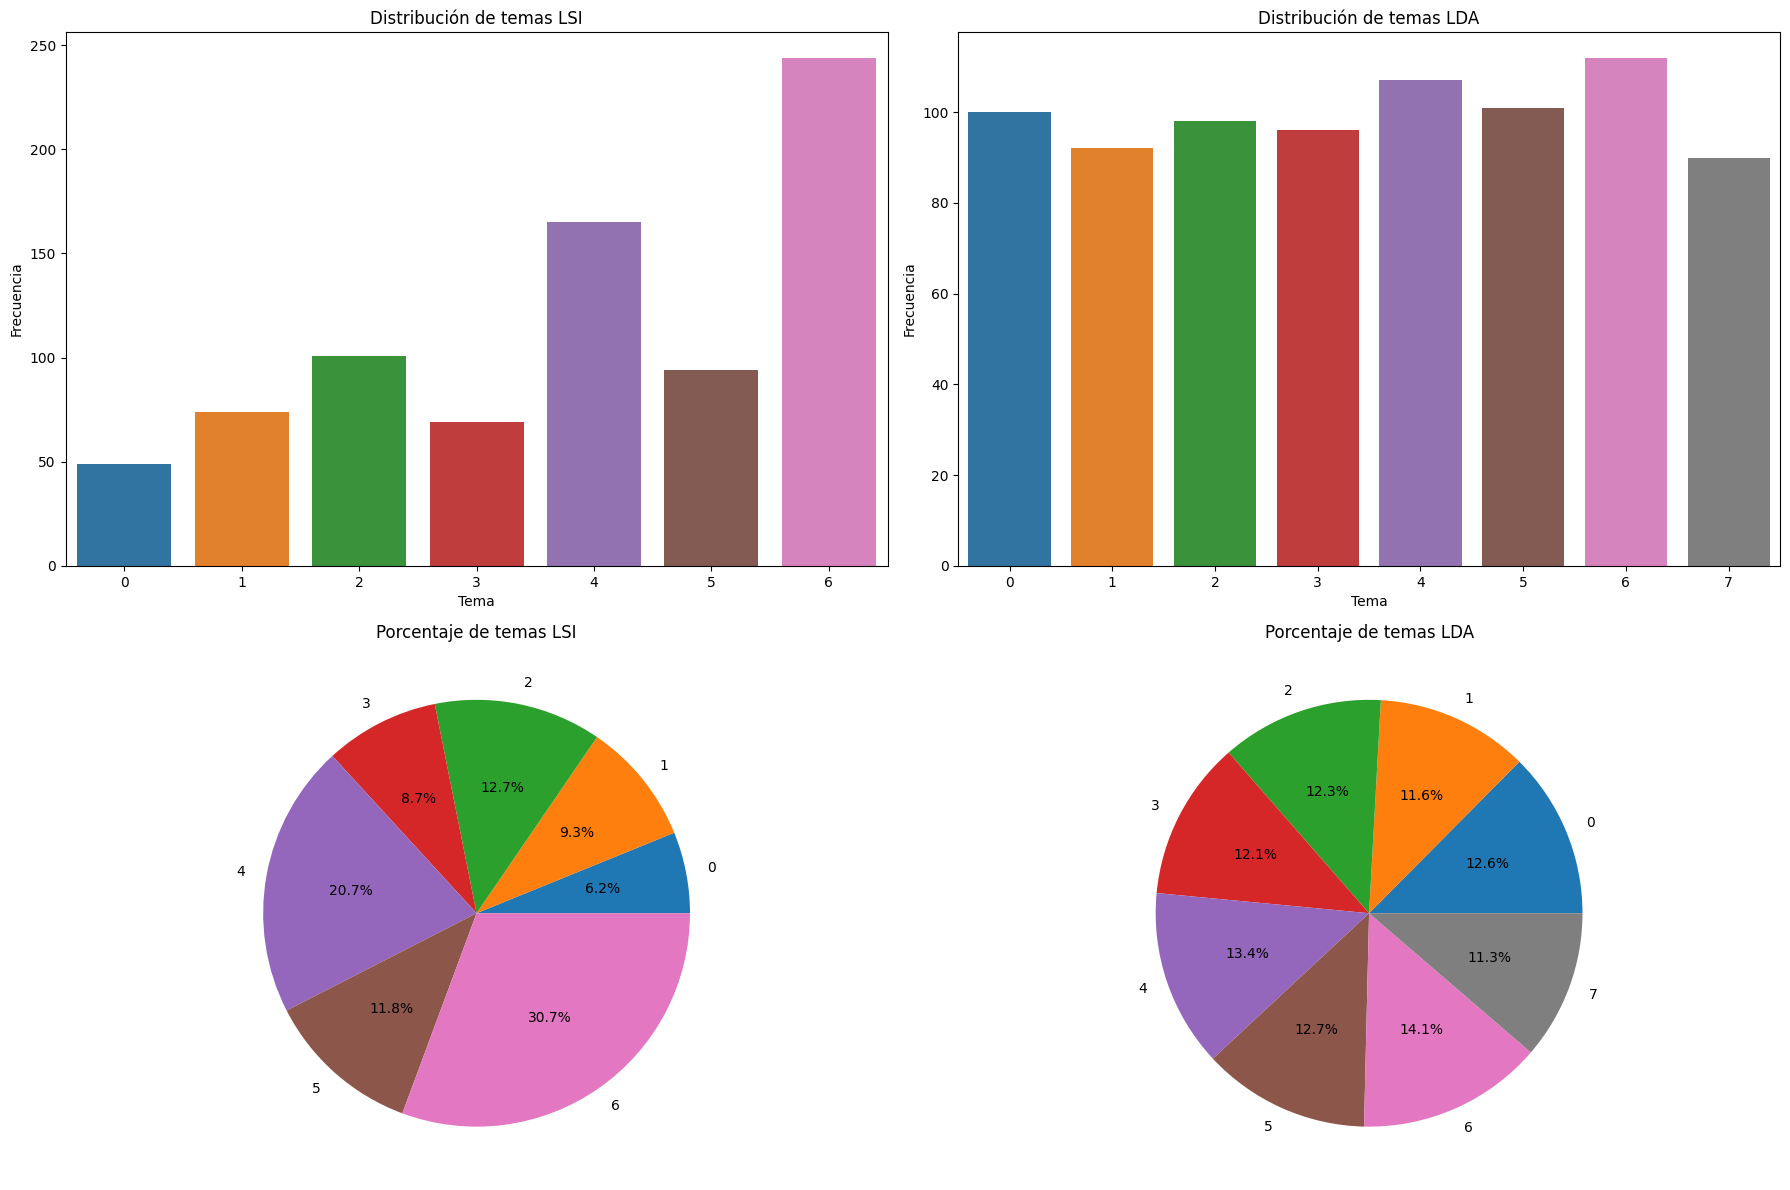

In [18]:
# Visualización de la cantidad de temas
temas_lsi = df['tema_lsi'].value_counts().reset_index().sort_values('tema_lsi', ascending=True)
temas_lda = df['tema_lda'].value_counts().reset_index().sort_values('tema_lda', ascending=True)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(data=temas_lsi, x="tema_lsi", y='count', palette='tab10', ax=axes[0][0])
axes[0][0].set_title('Distribución de temas LSI')
axes[0][0].set_xlabel('Tema')
axes[0][0].set_ylabel('Frecuencia')

sns.barplot(data=temas_lda, x="tema_lda", y='count', palette='tab10', ax=axes[0][1])
axes[0][1].set_title('Distribución de temas LDA')
axes[0][1].set_xlabel('Tema')
axes[0][1].set_ylabel('Frecuencia')

axes[1][0].pie(temas_lsi['count'], labels=temas_lsi['tema_lsi'], autopct='%1.1f%%')
axes[1][0].set_title('Porcentaje de temas LSI')

axes[1][1].pie(temas_lda['count'], labels=temas_lda['tema_lda'], autopct='%1.1f%%')
axes[1][1].set_title('Porcentaje de temas LDA')

plt.tight_layout()
plt.show()

## Guardar los temas por titular en un txt

In [19]:
temas = df.sort_values('tema_lsi')

with open(r'Division por topicos\temas_lsi.txt', 'w', encoding='utf-8') as f:
    for i in range(len(temas['tema_lsi'].unique())):
        f.write(f'Tema {i}:\n')
        f.write(f'{lsi_model.print_topic(i, topn=8)}\n')
        f.write('------------------------------------\n')
        for titular in temas[temas['tema_lsi'] == i]['titular']:
            f.write(titular + '\n')
        f.write('\n\n')

In [20]:
temas = df.sort_values('tema_lda')
f
with open(r'Division por topicos\temas_lda.txt', 'w', encoding='utf-8') as f:
    for i in range(len(temas['tema_lda'].unique())):
        f.write(f'Tema {i}:\n')
        f.write(f'{lda_model.print_topic(i, topn=8)}\n')
        f.write('------------------------------------\n')
        for titular in temas[temas['tema_lda'] == i]['titular']:
            f.write(titular + '\n')
        f.write('\n\n')